# Spell checker

In [2]:
#Importing the necessary libraries
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


# Defining functions that run one into the other leading up to a set corrections for a mispelt word (CANDIDATES function) as well as the most probable correction for the mistake (CORRECTION function) 

In [3]:
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

wordcount = []
for value in WORDS.values():
    wordcount.append(value)

total = sum(wordcount)

def P(word): 
    N = total
    "Probability of `word`."
    return (WORDS[word] / N)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

# CANDIDATES function - example

In [6]:
candidates('helo')

{'halo', 'held', 'hell', 'hello', 'helm', 'help', 'hero'}

# CORRECTION function - example

In [7]:
correction("helo")

'held'

# Exploratory Data Analysis on bag of words ('big.txt')

In [5]:
#just some EDA to explore the file we use as bag of words = 
WORDS.most_common(10)

[('the', 79809),
 ('of', 40024),
 ('and', 38312),
 ('to', 28765),
 ('in', 22023),
 ('a', 21124),
 ('that', 12512),
 ('he', 12401),
 ('was', 11410),
 ('it', 10681)]

In [8]:
#most popular word
max(WORDS, key=P)

'the'

In [7]:
#probability of the word the appearing in the WORDS file ("big.txt")
P('the')

0.071540044012782536

# Tokenizer function - listing words separated by a space as well as turning everything to lowercase (NORMALIZING)

In [10]:
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower())

In [12]:
tokens("I like Big BUTS and i cannot lie")

['i', 'like', 'big', 'buts', 'and', 'i', 'cannot', 'lie']

In [11]:
COUNTS = Counter(WORDS)
COUNTS['the']

79809

In [12]:
for w in tokens('the rare and neverbeforeseen words'):
    print (COUNTS[w], w)

79809 the
83 rare
38312 and
0 neverbeforeseen
460 words


# Tokenizer additional feature + example - used for words that are not separated by a space

In [ ]:
import wordsegment
from wordsegment import segment

segment('thisisatest')

# SPLITS function + example

In [13]:
def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [14]:
splits('neverseen')

[('', 'neverseen'),
 ('n', 'everseen'),
 ('ne', 'verseen'),
 ('nev', 'erseen'),
 ('neve', 'rseen'),
 ('never', 'seen'),
 ('nevers', 'een'),
 ('neverse', 'en'),
 ('neversee', 'n'),
 ('neverseen', '')]

# CORRECT function + example - finding the best spelling correction for any given word

In [13]:
def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

In [16]:
correct('helo')

'held'

# CORRECT_TEXT fucntion + example - building up from the CORRECT function where now we try to spell check sentences and not single words

In [18]:
def correct_text(text):
    "Correct all the words within a text, returning the corrected text."
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    "Spell-correct word in match, and preserve proper upper/lower/title case."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    "Return the case-function appropriate for text: upper, lower, title, or just str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

In [19]:
correct_text('Speling errurs in somethink. Whutever; unusuel misteakes everyware?')

'Spelling errors in something. Whatever; unusual mistakes everywhere?'

# PDIST function + example - finding the probability of occurrence of a given word. 

In [20]:
wordcount2 = []
for value in COUNTS.values():
    wordcount2.append(value)

total2 = sum(wordcount2)

def pdist(word): 
    N2 = total2
    "Probability of `word`."
    return lambda x: word[x] / N2

P = pdist(COUNTS)

In [21]:
for w in tokens('"The" is most common word in English'):
    print (P(w), w)

0.0715400440128 the
0.00876042614413 is
0.000813922740087 most
0.000255471344631 common
0.000267124423509 word
0.0197412120098 in
0.000188242043412 english


# PWORDS function + example - finding the probability of occurrence of a given word, assuming each word selection independence 

In [22]:
def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(P(w) for w in words)

def product(nums):
    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"
    result = 1
    for x in nums:
        result *= x
    return result

In [23]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a neverbeforeseen test']

for test in tests:
    print (Pwords(tokens(test)), test)

2.87022593818e-11 this is a test
8.23310012431e-16 this is a unusual test
0.0 this is a neverbeforeseen test


# Build up to probabilistic functions PWORDS, CPWORDS & PWORDS2 

In [24]:
def load_counts(filename, sep='\t'):
    """Return a Counter initialized from key-value pairs, 
    one on each line of filename."""
    C = Counter()
    for line in open(filename):
        key, count = line.split(sep)
        C[key] = int(count)
    return C

In [25]:
COUNTS1 = load_counts('count_1w.txt')
COUNTS2 = load_counts('count_2w.txt')

P1w = pdist(COUNTS1)
P2w = pdist(COUNTS2)

# PWORDS = probability of word occurrence assuming word selection independence

# CPWORDS = conditional probability - occurrence of one word given the presence of the previous one

# PWORDS2 = using bigram data, outputs probability of a sequence of words given previous words

In [26]:
def Pwords2(words, prev='<S>'):
    "The probability of a sequence of words, using bigram data, given prev word."
    return product(cPword(w, (prev if (i == 0) else words[i-1]) )
                   for (i, w) in enumerate(words))

# Change Pwords to use P1w (the bigger dictionary) instead of Pword
def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(P1w(w) for w in words)

def cPword(word, prev):
    "Conditional probability of word, given previous word."
    bigram = prev + ' ' + word
    if P2w(bigram) > 0 and P1w(prev) > 0:
        return P2w(bigram) / P1w(prev)
    else: # Average the back-off value and zero.
        return P1w(word) / 2

# User interface

In [27]:
def interface():
    a = input("enter some text: ")
    b = a 
    print("Spell-checked version:/n")
    return correct_text(b)

interface()

#Your sir, arew notf very nicew, you never pasd me the ball when I ask for it
#look at how it corrected pasd to past. It did not take into accout keyboard proximity. You need to add that feature.

enter some text: helo
Spell-checked version:/n


'held'

# Unigrams, Bigrams + NLTK Ngrams example

In [30]:
#N-grams

import wordsegment as ws
ws.load()
ws.UNIGRAMS['the']

23135851162.0

In [31]:
#<s> means starts with
ws.BIGRAMS['<s> where']

15419048.0

In [32]:
import heapq
from pprint import pprint
from operator import itemgetter
pprint(heapq.nlargest(10, ws.BIGRAMS.items(), itemgetter(1)))

[('of the', 2766332391.0),
 ('in the', 1628795324.0),
 ('to the', 1139248999.0),
 ('on the', 800328815.0),
 ('for the', 692874802.0),
 ('and the', 629726893.0),
 ('to be', 505148997.0),
 ('is a', 476718990.0),
 ('with the', 461331348.0),
 ('from the', 428303219.0)]


In [33]:
#NLTK n-grams, so that if we want we can tweak n and place whatever number we want. 

from nltk import ngrams
sentence = 'this is a foo bar sentences and i want to ngramize it'
n = 3
sixgrams = ngrams(sentence.split(), n)
for grams in sixgrams:
  print (grams)

('this', 'is', 'a')
('is', 'a', 'foo')
('a', 'foo', 'bar')
('foo', 'bar', 'sentences')
('bar', 'sentences', 'and')
('sentences', 'and', 'i')
('and', 'i', 'want')
('i', 'want', 'to')
('want', 'to', 'ngramize')
('to', 'ngramize', 'it')


In [34]:
def splitter(text):
    wordlist = list(text) 
    wordlist = ' '.join(wordlist).split()
    return wordlist

splitter("hello")

['h', 'e', 'l', 'l', 'o']

In [35]:
b = list(candidates("helo"))


for i in b:
    b = (i.split(','))
    print(b)

['hell']
['hero']
['held']
['halo']
['hello']
['helm']
['help']


# KEYBOARD_DISTANCE function + example

In [36]:
from math import sqrt

keyboard_cartesian = {'q': {'x':0, 'y':0}, 'w': {'x':1, 'y':0}, 'e': {'x':2, 'y':0}, 'r': {'x':3, 'y':0}, 't': {'x':4, 'y':0}, 'y': {'x':5, 'y':0}, 'u': {'x':6, 'y':0}, 'i': {'x':7, 'y':0}, 'o': {'x':8, 'y':0}, 'p': {'x':9, 'y':0}, 'a': {'x':0, 'y':1},'z': {'x':0, 'y':2},'s': {'x':1, 'y':1},'x': {'x':1, 'y':2},'d': {'x':2, 'y':1},'c': {'x':2, 'y':2}, 'f': {'x':3, 'y':1}, 'b': {'x':4, 'y':2}, 'm': {'x':5, 'y':2}, 'j': {'x':6, 'y':1}, 'g': {'x':4, 'y':1}, 'h': {'x':5, 'y':1}, 'j': {'x':6, 'y':1}, 'k': {'x':7, 'y':1}, 'l': {'x':8, 'y':1}, 'v': {'x':3, 'y':2}, 'n': {'x':5, 'y':2}, }

def keyboard_distance(a,b):
    X = (keyboard_cartesian[a]['x'] - keyboard_cartesian[b]['x'])**2
    Y = (keyboard_cartesian[a]['y'] - keyboard_cartesian[b]['y'])**2
    return math.sqrt(X+Y) 
     
keyboard_distance('q', 'p')

9.0

# LEVENSHTEIN distance + example

In [ ]:
import Levenshtein as lev

word1 = "focus"
word2 = "ficus"

lev.ratio(word1,word2)

# SOUNDEX 

In [49]:
#soundex

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

fuzz.ratio("ACME Factory", "ACME Factory Inc.")

83

# Tokenized SOUNDEX

In [50]:
fuzz.token_sort_ratio('Barack Obama', 'Barack H. Obama')

92

# MACHINE LEARNING - 
A process applied to the functions we developed. We will come up with a logistic regression as to analyze two distinct but deeply intertwined metrics:
Firstly, we analyze the coefficients of this binary classifier as to understand what weights are to be applied to the separte functions we created once they'll all be joined in a unique, fully-fledged application. 
Secondly, we compute the precision and recall of our model as to see how well the explanatory variable lead to the prediciton of our spell checker's performance. 

In [415]:
#let the machine learning start by loading the necessary files.
import pandas as pd

misspellings = pd.read_csv('/Users/filippofrezza/Desktop/IE/3rd term/NLP/data/misspellingg.csv',sep=';')
misp_list = list(misspellings['misspellings'])
misp_list = [element.lower() for element in misp_list]
correct_answers = list(misspellings['correct_answers'])
correct_answers = [element.lower() for element in correct_answers]

In [416]:
#coming up with the corrections for the list of misspelt words

df = []
for i in misp_list:
    df.append(correct_text(i))

In [417]:
#creating the initial dataframe

#misspellings = misspelt words
#correct_text = suggestion of our function for misspelt word
#correct_answers = answers of truth set

data = pd.DataFrame({'misspellings':misp_list,'correct_text':df,'correct_answers':correct_answers})

In [15]:
#creating binary variable as to see where our function - CORRECT_TEXT mathces the truth set = CORRECT_ANSWERS

data['correct'] =data.apply(lambda row: row['correct_text'] == row['correct_answers'],axis=1)

NameError: name 'data' is not defined

In [420]:
#building list of words to then insert in the tokenized soundex function

word1 = list(data['misspellings'])
word2 = list(data['correct_text'])  

In [424]:
#creating the my_soundex column

my_soundex = []

for i in range(len(word1)):
    my_soundex.append(fuzz.token_sort_ratio(word1[i],word2[i]))
    
data['my_soundex'] = my_soundex

In [426]:
#updating the dataframe

data = data[['correct_answers', 'correct_text', 'misspellings', 'my_levkey','my_soundex','correct']]

In [427]:
#this transforms the correct column previously created from TRUE & FALSE to 1s & 0s
data['correct'] = data['correct'] * 1

In [428]:
#creating a dictionary as to display all the solutions (CANDIDATES function) for a given misspelt word

candidates_dict = {}
for i in range(len(misp_list)):
    candidates_dict[misp_list[i]] = candidates(misp_list[i])

# CHECKER function + example - it checks whether the most the CORRECT_ANSWER for a misspelt word is within the list of words derived from our CANDIDATES function

In [429]:
def checker(misspell,correct):
    x = 0
    if misspell in candidates_dict.keys():
        misspell = str(misspell.lower())
        if correct in list(candidates_dict[misspell]):
            x = 1
            return("1")
        else:
            x = 0
            return("0")
    else:
        x = None
        return("2")
    
checker("circue","circle")

'1'

In [430]:
#building the candidates (binary variable) column in the dataframe

candidates_l = []
for i in range(len(misp_list)):
    candidates_l.append(checker(misp_list[i],correct_answers[i]))

data['candidates'] = candidates_l

# Build-up of weighted keyboard distance

In [431]:
#making a list where we take the correct answer if our candidates function has the correct answer in its output.
#If not, we append the first solution of our candidates function. 

candidate_list = []

for i in range(len(data)):
    if data['candidates'][i] == '1':
        candidate_list.append(data['correct_answers'][i])
    else:
        candidate_list.append(list(candidates(misp_list[i]))[0])        

In [432]:
#making words of equal length

candidate_list2 = candidate_list
correct_answers2 = list(data['correct_answers'])

for i in range(len(candidate_list2)):
    if len(candidate_list2[i]) > len(correct_answers2[i]):
        candidate_list2[i] = candidate_list2[i][:len(correct_answers2[i])]
    if len(correct_answers2[i]) > len(candidate_list2[i]):
        correct_answers2[i] = correct_answers2[i][:len(candidate_list2[i])]
    else:
        pass
    

In [433]:
#making a dictionary as to register the keyboard distance of letters amongst different words.

s = candidate_list2
t = correct_answers2

differences = {}

for i in range(len(s)):
    ss = candidate_list2[i]
    tt = correct_answers2[i]
    for j in range(len(ss)):
        if ss[j] != tt[j]:
            differences[misp_list[i]] = [ss[j],tt[j]]
        else:
            differences[misp_list[i]] = '0'

In [434]:
#keyboard_distance(differences[j][0],differences[j][1])

key_dist = []


letters = [differences[x] for x in differences]

for i in range(len(letters)):
    try:
        key_dist.append(keyboard_distance(letters[i][0],letters[i][1]))
    except:
        key_dist.append('0')

In [458]:
#the final output of this weighted keyboard distance process:

word1 = misp_list
word2 = list(data['correct_text'])

my_levkey = []

for i in range(len(misp_list)):
    my_levkey.append(lev.ratio(word1[i],word2[i])*float(key_dist[i]))
    
data['my_levkey'] = my_levkey

In [461]:
#just displaying how the created dataframe looks like

data.head(5)

,correct_answers,correct_text,misspellings,my_levkey,my_soundex,correct,candidates
0,occasionally,accosinly,accosinly,5.09902,100,0,0
1,circler,circular,ciculer,0.80000,80,0,0
2,circle,circle,circue,0.00000,83,1,1
3,madness,madness,maddness,0.00000,93,1,1
4,occasionally,occasionally,occusionaly,0.00000,87,1,1


# Logistic regression - dependent variable = CORRECT

In [463]:
#logistic regression - sci kit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from patsy import dmatrices

df_train = data.iloc[ 0: 437, : ] 
df_test = data.iloc[ 437: , : ]
formula = 'correct~my_levkey+my_soundex+candidates'
y_train,x_train = dmatrices(formula, data=df_train, return_type='dataframe') 
y_test,x_test = dmatrices(formula, data=df_test, return_type='dataframe')

model = LogisticRegression()
model = model.fit(x_train, y_train.correct)

# Coefficient Analysis

In [464]:
# examine the coefficients
pd.DataFrame(list(zip(x_train.columns, np.transpose(model.coef_))))

,0,1
0,Intercept,[-2.27795324531]
1,candidates[T.1],[3.81605340078]
2,my_levkey,[-1.28491520046]
3,my_soundex,[0.0233931292821]


# Precision & Recall 

In [465]:
#precision & recall

y_pred = model.predict_proba(x_test)
y_pred_flag = y_pred[:,1] > 0.5


print (pd.crosstab(y_test.correct
                  ,y_pred_flag
                  ,rownames = ['Actual']
                  ,colnames = ['Predicted']))

print ('\n \n')

print (classification_report(y_test,y_pred_flag))

Predicted  False  True 
Actual                 
0.0           51     15
1.0            0     43

 

             precision    recall  f1-score   support

        0.0       1.00      0.77      0.87        66
        1.0       0.74      1.00      0.85        43

avg / total       0.90      0.86      0.86       109



# ROC curve + plot

In [466]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.935342


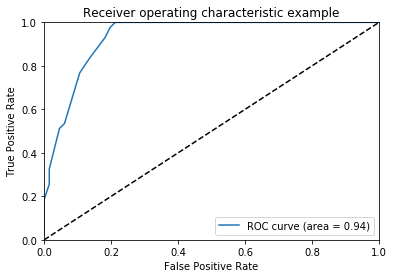

In [467]:
# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()